**Pricing options and computing implied volatilities
using neural networks**

## Option Pricing using Black Scholes

In [19]:
import torch
import warnings
import numpy as np
import torchvision
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.init as init
from scipy.stats import norm
from joblib import dump, load
import matplotlib.pyplot as plt
from colorama import Fore, Style
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore", category=UserWarning, message=".*target size.*different to the input size.*")

*Table 2. The Selected Model After the Random Search*

<div>
    <style>
        table {
            border-collapse: collapse;
            width: 50%;
            margin: 20px auto;
            font-family: Arial, sans-serif;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
        }
    </style>
    <table>
        <thead>
            <tr>
                <th>Parameter</th>
                <th>Option</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>Hidden layers</td>
                <td>4</td>
            </tr>
            <tr>
                <td>Neurons (each layer)</td>
                <td>400</td>
            </tr>
            <tr>
                <td>Activation</td>
                <td>ReLU</td>
            </tr>
            <tr>
                <td>Dropout rate</td>
                <td>0.0</td>
            </tr>
            <tr>
                <td>Batch-normalization</td>
                <td>No</td>
            </tr>
            <tr>
                <td>Initialization</td>
                <td>Glorot_uniform</td>
            </tr>
            <tr>
                <td>Optimizer</td>
                <td>Adam</td>
            </tr>
            <tr>
                <td>Batch size</td>
                <td>1024</td>
            </tr>
        </tbody>
    </table>
</div>

In [3]:
class ANN_BlackScholes(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ANN_BlackScholes, self).__init__()

        ''' Define layers '''
        self.fc1 = nn.Linear(input_size, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, 400)
        self.fc4 = nn.Linear(400, 400)
        self.fc5 = nn.Linear(400, 1)

        ''' Activation and dropout '''
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.0)

        ''' Apply Glorot (Xavier) initialization to the weights '''
        self._initialize_weights()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

    def _initialize_weights(self):
        ''' Apply Glorot (Xavier) initialization to all layers '''
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)
        init.xavier_uniform_(self.fc3.weight)
        init.xavier_uniform_(self.fc4.weight)
        init.xavier_uniform_(self.fc5.weight)

Data Generation

In [4]:
torch.manual_seed(42)
np.random.seed(42)

In [5]:
batch_size = 1024
Sample_Size = 1000000

In [6]:
def Black_Scholes(money_ness, T, r, sigma):
  d1 = (np.log(money_ness) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  Call_Prices = money_ness * norm.cdf(d1) - np.exp(-r * T) * norm.cdf(d2)
  return Call_Prices

In [7]:
'''
Generate random values for the parameters
'''
SK = np.random.uniform(0.4, 1.6, Sample_Size)
T = np.random.uniform(0.2, 1.1, Sample_Size)
r = np.random.uniform(0.02, 0.1, Sample_Size)
sigma = np.random.uniform(0.01, 1.0, Sample_Size)


'''
Calculate the call option prices using the Black-Scholes equation
'''
call_prices = Black_Scholes(SK, T, r, sigma)


'''
Create a DataFrame to store the dataset
'''
df = pd.DataFrame({
    'MoneyNess (K)': SK,
    'Time to Maturity (T)': T,
    'Risk-Free Rate (r)': r,
    'Volatility (sigma)': sigma,
    'Call Option Price': call_prices
})

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

In [8]:
scaler = MinMaxScaler()
train_df['Call Option Price'] = scaler.fit_transform(train_df['Call Option Price'].values.reshape(-1, 1))
test_df['Call Option Price'] = scaler.transform(test_df['Call Option Price'].values.reshape(-1, 1))

In [9]:
X_train = train_df[['MoneyNess (K)', 'Time to Maturity (T)', 'Risk-Free Rate (r)', 'Volatility (sigma)']].values
y_train = train_df['Call Option Price'].values

X_test = test_df[['MoneyNess (K)', 'Time to Maturity (T)', 'Risk-Free Rate (r)', 'Volatility (sigma)']].values
y_test = test_df['Call Option Price'].values

''' Convert to PyTorch tensors '''
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

''' Create TensorDataset '''
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

''' Create DataLoader '''
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
def train(model, train_loader, criterion, optimizer, num_epochs, scaler):
    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        all_targets_scaled = []
        all_predictions_scaled = []

        ''' Create a progress bar for the current epoch '''
        pbar = tqdm(
            train_loader,
            desc=f"{Fore.GREEN}Epoch {epoch + 1}/{num_epochs}{Style.RESET_ALL}",
            ncols=100,
            dynamic_ncols=True,
            bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]",
        )

        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            output = model(data)
            target = target.view_as(output)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            ''' Collect scaled predictions and targets for metrics calculation '''
            all_predictions_scaled.extend(output.detach().cpu().numpy())
            all_targets_scaled.extend(target.detach().cpu().numpy())

            ''' Update the progress bar with batch loss '''
            pbar.set_postfix({
                f"{Fore.YELLOW}Batch Loss{Style.RESET_ALL}": f"{loss.item():.6f}"
            })

        ''' Reshape before inverse transform '''
        all_predictions_scaled = np.array(all_predictions_scaled).reshape(-1, 1)
        all_targets_scaled = np.array(all_targets_scaled).reshape(-1, 1)

        ''' Reverse transform predictions and targets to original scale '''
        all_predictions = scaler.inverse_transform(all_predictions_scaled).flatten()
        all_targets = scaler.inverse_transform(all_targets_scaled).flatten()

        ''' Calculate metrics for the epoch '''
        mse = mean_squared_error(all_targets, all_predictions)
        mae = mean_absolute_error(all_targets, all_predictions)
        avg_loss = epoch_loss / len(train_loader)

        train_losses.append(avg_loss)
        print(
            f"{Fore.CYAN}Results :{Style.RESET_ALL} "
            f"{Fore.MAGENTA}Average Loss:{Style.RESET_ALL} {avg_loss:.6f}, "
            f"{Fore.MAGENTA}MSE:{Style.RESET_ALL} {mse:.6f}, "
            f"{Fore.MAGENTA}MAE:{Style.RESET_ALL} {mae:.6f}\n"
        )

    return train_losses

In [11]:
def test(model, test_loader, scaler):
    model.eval()
    test_loss = 0
    y_pred_scaled = []
    y_true_scaled = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            y_pred_scaled.extend(output.cpu().numpy())
            y_true_scaled.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    y_pred = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).flatten()
    y_true = scaler.inverse_transform(np.array(y_true_scaled).reshape(-1, 1)).flatten()

    ''' Calculate metrics on original scale '''
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return mse, mae, r2

In [12]:
def plot_loss_history(history):
    epochs = range(1, len(history) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history, label="Training Loss", color='b', marker='o', linestyle='-', markersize=6)

    plt.title("Training Loss Over Epochs", fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)

    plt.grid(True)
    plt.legend(loc='upper right')

    plt.show()

In [13]:
model = ANN_BlackScholes(input_size=4, num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
epoch = 25

Epoch 1/25: 100%|██████████| 879/879 [00:21<00:00]


Results : Average Loss: 0.002415, MSE: 0.001971, MAE: 0.013673



Epoch 2/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.000051, MSE: 0.000041, MAE: 0.004627



Epoch 3/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.000043, MSE: 0.000035, MAE: 0.003585



Epoch 4/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.000028, MSE: 0.000023, MAE: 0.002321



Epoch 5/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.000027, MSE: 0.000022, MAE: 0.002831



Epoch 6/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.000023, MSE: 0.000019, MAE: 0.002917



Epoch 7/25: 100%|██████████| 879/879 [00:15<00:00]


Results : Average Loss: 0.000024, MSE: 0.000020, MAE: 0.002362



Epoch 8/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.000020, MSE: 0.000016, MAE: 0.002313



Epoch 9/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.000017, MSE: 0.000014, MAE: 0.002155



Epoch 10/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.000015, MSE: 0.000012, MAE: 0.002322



Epoch 11/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.000015, MSE: 0.000012, MAE: 0.002328



Epoch 12/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.000013, MSE: 0.000010, MAE: 0.001870



Epoch 13/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.000011, MSE: 0.000009, MAE: 0.001941



Epoch 14/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.000011, MSE: 0.000009, MAE: 0.001649



Epoch 15/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.000009, MSE: 0.000007, MAE: 0.001573



Epoch 16/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.000009, MSE: 0.000007, MAE: 0.001751



Epoch 17/25: 100%|██████████| 879/879 [00:15<00:00]


Results : Average Loss: 0.000007, MSE: 0.000006, MAE: 0.001541



Epoch 18/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.000007, MSE: 0.000006, MAE: 0.001434



Epoch 19/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.000007, MSE: 0.000006, MAE: 0.001573



Epoch 20/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.000006, MSE: 0.000005, MAE: 0.001336



Epoch 21/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.000006, MSE: 0.000005, MAE: 0.001269



Epoch 22/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.000006, MSE: 0.000005, MAE: 0.001305



Epoch 23/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.000005, MSE: 0.000004, MAE: 0.001177



Epoch 24/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.000005, MSE: 0.000004, MAE: 0.001160



Epoch 25/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.000005, MSE: 0.000004, MAE: 0.001148



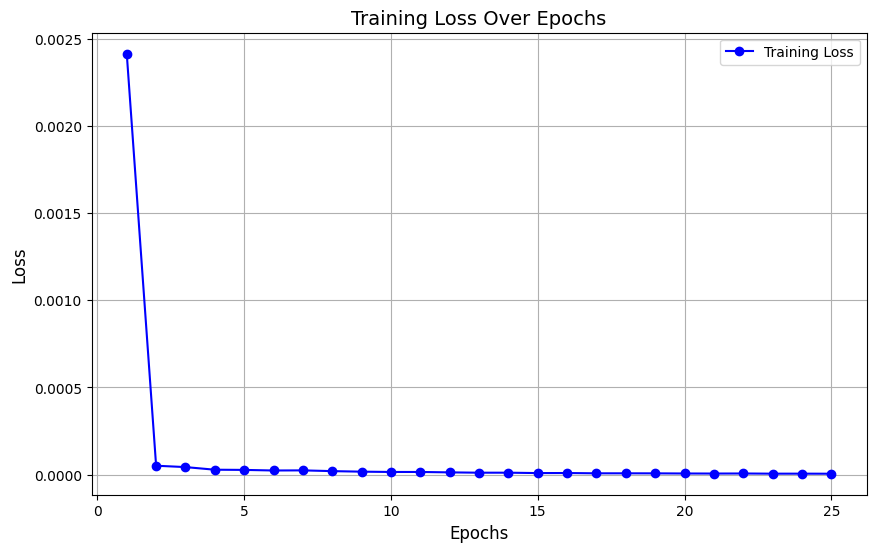

In [15]:
history = train(model, train_loader, criterion, optimizer, epoch, scaler)
plot_loss_history(history)

Eveluation on Test Data

In [16]:
mse, mae, r2 = test(model, test_loader,scaler)
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error (MSE): 0.0001
Mean Absolute Error (MAE): 0.0075
R² Score: 0.9984


Eveluation on Train Data

In [17]:
mse, mae, r2 = test(model, train_loader,scaler)
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error (MSE): 0.0001
Mean Absolute Error (MAE): 0.0075
R² Score: 0.9984


Save the Models

In [20]:
'''
Saving Standard Scaler for future use
'''
dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [22]:
'''
Save the model for future use
'''
torch.save(model.state_dict(), '/content/Option_Pricing_Model.pth')

## Implied Volatility using Black Scholes

In [23]:
''' Reverse the scalled data '''
train_df['Call Option Price'] = scaler.inverse_transform(train_df['Call Option Price'].values.reshape(-1, 1))
test_df['Call Option Price'] = scaler.inverse_transform(test_df['Call Option Price'].values.reshape(-1, 1))

In [24]:
scaler1 = MinMaxScaler()
train_df['Volatility (sigma)'] = scaler1.fit_transform(train_df['Volatility (sigma)'].values.reshape(-1, 1))
test_df['Volatility (sigma)'] = scaler1.transform(test_df['Volatility (sigma)'].values.reshape(-1, 1))

In [25]:
X_train = train_df[['MoneyNess (K)', 'Time to Maturity (T)', 'Risk-Free Rate (r)','Call Option Price']].values
y_train = train_df['Volatility (sigma)'].values

X_test = test_df[['MoneyNess (K)', 'Time to Maturity (T)', 'Risk-Free Rate (r)','Call Option Price']].values
y_test = test_df['Volatility (sigma)'].values

''' Convert to PyTorch tensors '''
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

''' Create TensorDataset '''
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

''' Create Train loader and Test Loader '''
train_loader1 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
model_implied = ANN_BlackScholes(input_size=4, num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_implied.parameters(), lr=0.0001)

Epoch 1/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.027438, MSE: 0.026894, MAE: 0.115910



Epoch 2/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.006779, MSE: 0.006644, MAE: 0.051321



Epoch 3/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.004539, MSE: 0.004449, MAE: 0.038757



Epoch 4/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.003861, MSE: 0.003785, MAE: 0.034996



Epoch 5/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.003298, MSE: 0.003232, MAE: 0.031262



Epoch 6/25: 100%|██████████| 879/879 [00:16<00:00]


Results : Average Loss: 0.002920, MSE: 0.002862, MAE: 0.028820



Epoch 7/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.002804, MSE: 0.002748, MAE: 0.028331



Epoch 8/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.002640, MSE: 0.002587, MAE: 0.027166



Epoch 9/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.002483, MSE: 0.002434, MAE: 0.026115



Epoch 10/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.002475, MSE: 0.002426, MAE: 0.026120



Epoch 11/25: 100%|██████████| 879/879 [00:15<00:00]


Results : Average Loss: 0.002294, MSE: 0.002249, MAE: 0.024790



Epoch 12/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.002264, MSE: 0.002219, MAE: 0.024679



Epoch 13/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.002231, MSE: 0.002187, MAE: 0.024309



Epoch 14/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.002111, MSE: 0.002069, MAE: 0.023395



Epoch 15/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.002152, MSE: 0.002110, MAE: 0.023841



Epoch 16/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.002073, MSE: 0.002032, MAE: 0.023218



Epoch 17/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.002052, MSE: 0.002011, MAE: 0.023022



Epoch 18/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.002029, MSE: 0.001989, MAE: 0.022864



Epoch 19/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.001935, MSE: 0.001896, MAE: 0.021934



Epoch 20/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.001968, MSE: 0.001929, MAE: 0.022384



Epoch 21/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.001926, MSE: 0.001888, MAE: 0.021998



Epoch 22/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.001919, MSE: 0.001881, MAE: 0.021989



Epoch 23/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.001866, MSE: 0.001829, MAE: 0.021502



Epoch 24/25: 100%|██████████| 879/879 [00:13<00:00]


Results : Average Loss: 0.001833, MSE: 0.001797, MAE: 0.021474



Epoch 25/25: 100%|██████████| 879/879 [00:14<00:00]


Results : Average Loss: 0.001829, MSE: 0.001793, MAE: 0.021298



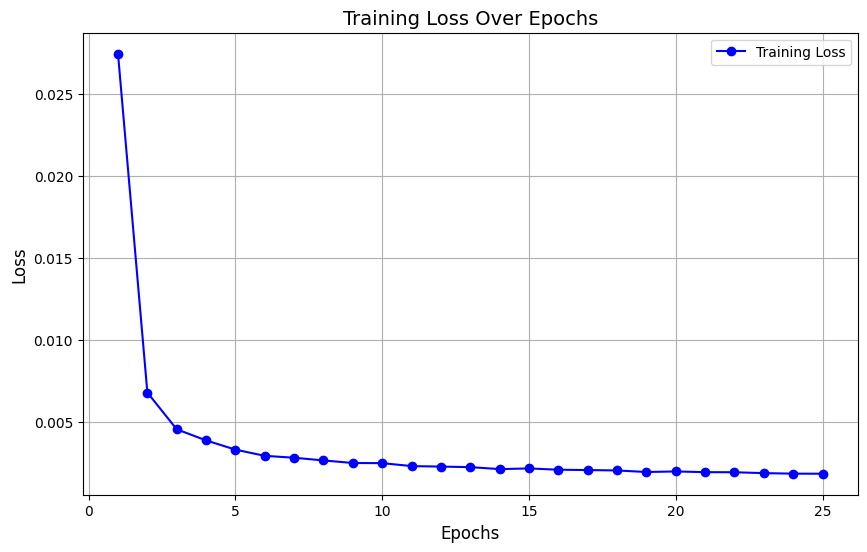

In [27]:
history = train(model_implied, train_loader1, criterion, optimizer, epoch, scaler1)
plot_loss_history(history)

Eveluation on Test Data

In [28]:
mse, mae, r2 = test(model_implied, test_loader1,scaler1)
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error (MSE): 0.0017
Mean Absolute Error (MAE): 0.0177
R² Score: 0.9793


Eveluation on Training Data

In [29]:
mse, mae, r2 = test(model_implied, train_loader1,scaler1)
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

Mean Squared Error (MSE): 0.0017
Mean Absolute Error (MAE): 0.0176
R² Score: 0.9793
